# Download Data

In [1]:
# !wget --header="Host: mftp.mmcheng.net" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.131 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: en-US,en;q=0.9,ar;q=0.8" "http://mftp.mmcheng.net/Data/MSRA10K_Imgs_GT.zip" -O "MSRA10K_Imgs_GT.zip" -c
# !mkdir MSRA_Dataset
# !mv MSRA10K_Imgs_GT.zip MSRA_Dataset/MSRA10K_Imgs_GT.zip
# %cd MSRA_Dataset
# !unzip -qq MSRA10K_Imgs_GT.zip
# !rm MSRA_10K_Imgs_GT.zip
# !ls
# %cd ..

# Imports

In [5]:
import numpy as np

from enum import Enum

import cv2 as cv
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage import measure
from skimage.segmentation import random_walker

import scipy
from skimage import data, filters

Matplotlib is building the font cache using fc-list. This may take a moment.


# Load Data

In [6]:
class Seed(Enum):
  B = 1
  F = 2
  
class Region(Enum):
  SF = 10
  WF = 80
  WB = 160
  SB = 240

def load_data(path):
  masks  = {}
  images = {}
  for l in tqdm(list(path.glob('*.png'))):
    id = l.parts[-1].split('.')[0]
    mask = cv.imread(str(l))
    masks[int(id)] = mask
    
  for l in tqdm(list(path.glob('*.jpg'))):
    id = l.parts[-1].split('.')[0]
    image = cv.imread(str(l))
    images[int(id)] = image
    
  ids = sorted(list(images.keys()))
  images_, masks_ = [], []
  for id in ids:
    images_.append(images[id])
    masks_.append(masks[id])
    
  return images_, masks_

def resize_data(images, masks, new_size=(84,84)):
  for i, (image, mask) in enumerate(zip(images, masks)):
    images[i] = cv.resize(image, new_size)
    masks[i]  = cv.resize(mask, new_size)
    
  return images, masks



def create_seed_mask(center, value=Seed.B, diameter=3, size=(84, 84)):
  '''
  Takes coordinates and type of seed point, diameter and image size and returns an
  image of the same size containing the value (Seed.F or Seed.B) in the pixels
  forming the seed points
  
  params
  ---------
  center:    (row, col) tuple
             Center pixel of the seed points
  
  value:     {Seed.F, Seed.B} enum
             Type of the seed point either F (Foreground) / B (Background)
  
  diameter:  int
             Diameter of the seed point in pixels (3 at train time / 13 at test time)
  
  size:      tuple
             Size of the resulting mask
  '''
  value = value.value
  grid = np.meshgrid(np.arange(size[0]), np.arange(size[1]))
  sum_grid = (grid[0] - center[1]) ** 2 + (grid[1] - center[0]) ** 2
  idxs = np.where((sum_grid) <= (diameter/2)**2)
  seed_image = np.zeros_like(image)
  seed_image[idxs] = value
  return seed_image

def merge_seed_masks(masks):
  final_result = np.zeros_like(masks[0])
  for mask in masks:
    final_result += mask
  final_result[final_result >= 3] = 2
  
  return final_result

def calculate_IoU(mask1, mask2):
  if len(mask1.shape) > 2:
    mask1 = mask1[:,:,0]
    
  if len(mask2.shape) > 2:
    mask2 = mask2[:,:,0]
  
  idxs1 = np.where(mask1 > 0)
  idxs2 = np.where(mask2 > 0)
  
  idxs1 = set([(x, y) for x, y in zip(idxs1[0], idxs1[1])])
  idxs2 = set([(x, y) for x, y in zip(idxs2[0], idxs2[1])])
  
  intersection = len(idxs1.intersection(idxs2))
  union        = len(idxs1.union(idxs2))
  
  
  return intersection/union

In [7]:
path = Path('./MSRA_Dataset/MSRA10K_Imgs_GT/Imgs/')
images, masks = load_data(path)
print(f'\nThe data contains {len(images)} images')

100%|██████████| 10000/10000 [00:13<00:00, 745.00it/s]



The data contains 10000 images


In [8]:
images, masks = resize_data(images, masks)
images = np.array(images)
masks  = np.array(masks)[:,:,:,0]
masks[masks>0] = 255

print(images.shape, masks.shape)

(10000, 84, 84, 3) (10000, 84, 84)


Text(0.5, 1.0, 'Seeds used for mask generation using random walker')

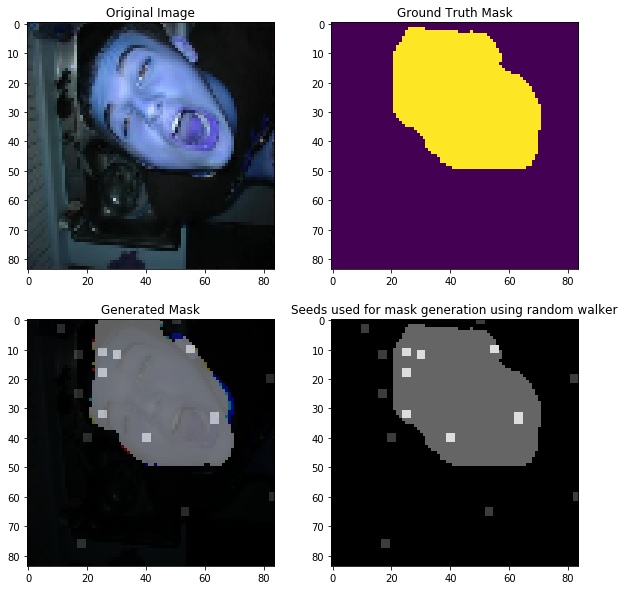

In [9]:
idx=6262
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0][0].imshow(images[idx])
axs[0][0].set_title('Original Image')
axs[0][1].imshow(masks[idx])
axs[0][1].set_title('Ground Truth Mask')

image = images[idx]
mask1 = create_seed_mask((18, 25), value=Seed.F)
mask2 = create_seed_mask((34, 63), value=Seed.F)
mask3 = create_seed_mask((12, 30), value=Seed.F)
mask4 = create_seed_mask((33, 63), value=Seed.F)
mask5 = create_seed_mask((11, 25), value=Seed.F)
mask6 = create_seed_mask((65, 53), value=Seed.B)
mask7 = create_seed_mask((20, 82), value=Seed.B)
mask8 = create_seed_mask((3, 11), value=Seed.B)
mask9 = create_seed_mask((76, 18), value=Seed.B)
mask10 = create_seed_mask((60, 83), value=Seed.B)
mask11 = create_seed_mask((40, 40), value=Seed.F)
mask12 = create_seed_mask((40, 20), value=Seed.B)
mask13 = create_seed_mask((32, 25), value=Seed.F)
mask14 = create_seed_mask((0, 50), value=Seed.B)
mask15 = create_seed_mask((10, 55), value=Seed.F)
mask16 = create_seed_mask((12, 17), value=Seed.B)
mask17 = create_seed_mask((25, 17), value=Seed.B)

final_mask = merge_seed_masks([mask1, mask2, mask3, mask4, mask5, mask6, mask7, mask8, mask9, mask10, mask11, mask12, mask13, mask14, mask15, mask16, mask17])
results = random_walker(image, final_mask, beta=150)
results[results!=Seed.F.value] = 0

axs[1][0].imshow(images[idx])
axs[1][0].imshow(results*100, alpha=0.8)
axs[1][0].imshow(final_mask*100,alpha=0.4)
axs[1][0].set_title('Generated Mask')
axs[1][1].imshow(final_mask*100)
axs[1][1].imshow(masks[idx], alpha=0.4, cmap='gray')
axs[1][1].set_title('Seeds used for mask generation using random walker')

# Image Regions for Reward Calculation

## Retarded Method

In [10]:
def get_image_gradients(image, degrees=True):
  sobelx = cv.Sobel(image,cv.CV_64F,1,0,ksize=5)
  sobely = cv.Sobel(image,cv.CV_64F,0,1,ksize=5)
  gradient = np.arctan2(sobely, sobelx)
  if degrees:
    gradient = gradient * 180 / np.pi
    
  return gradient
  

def get_points_on_line(point, angle, size=(84, 84)):
  x, y = point
  slope = np.tan((angle) * np.pi/180)
  intercept = x - y * slope

  grid = np.meshgrid(np.arange(size[0]), np.arange(size[1]))

  result = (grid[0] * slope + intercept) - grid[1]

  tmp1 = np.zeros(size)
  tmp1[np.abs(result) < 0.2] = 255
  
  
  return tmp1

def get_points_within_range(line, point, depth):
  x, y = point
  idxs = np.where(line == 255)
  valid_pts = ((idxs[0] - x) ** 2 +(idxs[1] - y) ** 2) < (depth ** 2)
  idxs = (idxs[0][valid_pts], idxs[1][valid_pts])
  tmp1 = np.zeros_like(line)
  tmp1[idxs] = 255

  return tmp1, idxs

def get_points_in_same_direction(point, indices, angle, thresh=3):
  x, y = point
  angles = np.arctan2((indices[0] - x), (indices[1] - y)) * 180 / np.pi
  angles[angles < 0] = angles[angles < 0] + 360
  
  idxs2 = np.where(np.abs(angles - angle) < thresh)
  indices = (indices[0][idxs2], indices[1][idxs2]) 
  
  return indices

def get_points_in_opposite_direction(point, indices, angle, thresh=3):
  x, y = point
  angles = np.arctan2((indices[0] - x), (indices[1] - y)) * 180 / np.pi
  angles[angles < 0] = angles[angles < 0] + 360
  idxs2 = np.where(np.abs(np.abs(angles - angle) - 180) < thresh)
  indices = (indices[0][idxs2], indices[1][idxs2]) 
  
  return indices

def get_WF_region_indices(point, gradient, depth):
  x, y = point
  angle = -gradient[x, y]
  
  if angle < 0:
    angle += 360
  
  line = get_points_on_line(point, angle)
  points_within_range, indices = get_points_within_range(line, point, depth)
  indices = get_points_in_same_direction(point, indices, angle)
    
  return indices

def get_WB_region_indices(point, gradients, depth):
  x, y = point
  angle = -gradients[x, y]
  
  if angle < 0:
    angle += 360
  
    
  line = get_points_on_line(point, angle)
  
  points_within_range, indices = get_points_within_range(line, point, depth)
  indices = get_points_in_opposite_direction(point, indices, angle)
    
  return indices

def get_mask_WB_region(mask, depth, value=255):
  mask = mask.copy()
  mask[mask > 0] = 255
  edges = cv.Canny(mask, 100, 200)
  gradient = get_image_gradients(mask)
  
  WB_region = np.zeros_like(mask)
  
  
  indices_to_loop = np.where(edges != 0)

  for x, y in zip(indices_to_loop[0], indices_to_loop[1]):
    indices = get_SB_region_indices((x, y), gradient, depth)
    WB_region[indices] = value
    WB_region[x, y]    = value
    
  fltr = np.array([[1, 1, 1],
                  [1, 1, 1],
                  [1, 1, 1]], dtype='float32') / 9
  
  WB_region_filtered = scipy.signal.convolve2d(WB_region[:, :, 0], fltr, 'same')
  WB_region_filtered = np.round(WB_region_filtered)

  WB_region_filtered *= 255
  WB_region_filtered[WB_region_filtered > 255] = 255
    
  return WB_region_filtered

def get_mask_WF_region(mask, depth, value=1):
  mask = mask.copy()
  mask[mask > 0] = 255
  edges = cv.Canny(mask, 100, 200)
  gradient = get_image_gradients(mask)
  
  WF_region = np.zeros_like(mask)

  indices_to_loop = np.where(edges != 0)

  for x, y in zip(indices_to_loop[0], indices_to_loop[1]):
    indices = get_WF_region_indices((x, y), gradient, depth)
    WF_region[indices] = value
    WF_region[x, y]    = value
    
  fltr = np.array([[1, 1, 1],
                  [1, 1, 1],
                  [1, 1, 1]], dtype='float32') / 9
  
  WF_region_filtered = scipy.signal.convolve2d(WF_region[:, :, 0], fltr, 'same')
  WF_region_filtered = np.round(WF_region_filtered)

  WF_region_filtered *= 255
  WF_region_filtered[WF_region_filtered > 255] = 255
  return WF_region_filtered

def get_all_regions(mask):
  
  final_FW = np.zeros_like(mask)
  final_BW = np.zeros_like(mask)
  
  
  WF_region = get_mask_WF_region(mask, depth=1, value=Region.WF.value)
  _, SF_region = cv.threshold(mask,127,255,cv.THRESH_BINARY)
  SF_region[SF_region != 0] = Region.SF.value
  
  
  final_FW = SF_region.copy()
  idxs1 = np.where(WF_region != 0)
  final_FW[idxs1] = WF_region[idxs1]
  
  WB_region = get_mask_WB_region(mask, depth=1, value=Region.WB.value)
  _, SB_region = cv.threshold(mask,127,255,cv.THRESH_BINARY_INV)
  SB_region[SB_region != 0] = Region.SB.value
  
  final_BW = SB_region.copy()
  idxs2 = np.where(WB_region != 0)
  final_BW[idxs2] = WB_region[idxs2]
  print(np.sum(idxs1))
  print(np.sum(idxs2))
  fig, axs = plt.subplots(1, 2)
  axs[0].imshow(final_FW)
  axs[1].imshow(final_BW)

In [13]:
# get_all_regions(mask)

In [14]:
# idx= 6561
# image = images[idx]
# mask = masks[idx]
# WB_region = get_mask_WB_region(mask, depth=3, value=255)
# WF_region = get_mask_WF_region(mask, depth=3, value=255)

# fig, axs = plt.subplots(1, 2, figsize=(10, 10))

# axs[0].imshow(image)

# # axs[1].imshow(image)
# axs[1].imshow(mask[:,:,0],alpha=0.5)
# axs[1].imshow(WF_region, alpha=0.5, cmap='gray')
# axs[1].imshow(WB_region, alpha=0.5, cmap='jet')


## Smart Method

In [15]:
def get_image_different_regions(mask, threshold=1.5):
  if len(mask.shape) > 2:
    mask = mask[:,:,0]

  mask[mask != 0] = 255
  edges = cv.Canny(mask, 100, 200)
  dist = cv.distanceTransform(~edges, distanceType=cv.DIST_L2, maskSize=cv.DIST_MASK_PRECISE)
  
  all_regions = np.zeros_like(mask)
  all_regions[(dist>=threshold) & (mask==255)] = Region.SF.value   # sf
  all_regions[(dist<threshold) & (mask==255)]  = Region.WF.value   # wf
  all_regions[(dist>=threshold) & (mask==0)]   = Region.SB.value   # sb
  all_regions[(dist<threshold) & (mask==0)]    = Region.WB.value   # wb
  
  return all_regions

def get_all_different_regions(masks, threshold=1.5):
  if len(masks.shape) > 3:
    masks = masks[:,:,:,0]
    
  all_masks_with_regions = masks.copy()
  
  for i in range(masks.shape[0]):
    mask = masks[i]
    all_masks_with_regions[i] = get_image_different_regions(mask, threshold=threshold)

  return all_masks_with_regions

In [16]:
all_masks_with_regions = get_all_different_regions(masks, threshold=2)

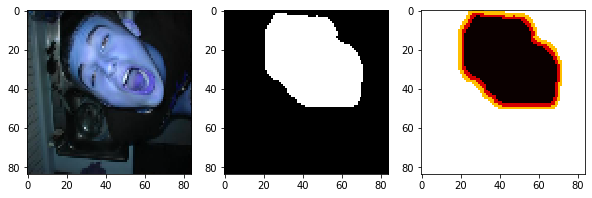

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(10,10))
idx = 6262
axs[0].imshow(images[idx])
axs[1].imshow(masks[idx], cmap='gray')
axs[2].imshow(all_masks_with_regions[idx], cmap='hot')

## Paper method (Dilation & Erosion)

In [18]:
def get_image_different_regions(mask, kernel_size, debug=True):
  kernel = np.ones(kernel_size ,np.uint8)
  eroded  = cv.erode(mask, kernel)
  dilated = cv.dilate(mask, kernel)
  
  SF_region = eroded
  WF_region = cv.bitwise_and(mask, cv.bitwise_not(eroded))
  WB_region = cv.bitwise_and(dilated, cv.bitwise_not(mask))
  SB_region = cv.bitwise_not(dilated)
  
  all_regions = np.zeros_like(mask)

  all_regions[np.where(WF_region>0)] = Region.WF.value
  all_regions[np.where(SF_region>0)] = Region.SF.value
  all_regions[np.where(WB_region > 0)] = Region.WB.value
  all_regions[np.where(SB_region > 0)] = Region.SB.value

  
  return all_regions

def get_all_different_regions(masks, kernel_size=(5,5)):
  if len(masks.shape) > 3:
    masks = masks[:,:,:,0]
    
  all_masks_with_regions = masks.copy()
  for i in range(masks.shape[0]):
    mask = masks[i]
    all_masks_with_regions[i] = get_image_different_regions(mask, kernel_size=kernel_size)
  return all_masks_with_regions

In [21]:
all_masks_with_regions = get_all_different_regions(masks, kernel_size=(5,5))

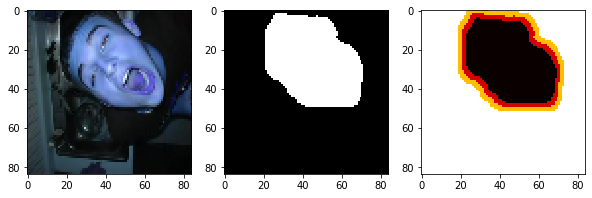

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(10,10))
idx = 6262
axs[0].imshow(images[idx])
axs[1].imshow(masks[idx], cmap='gray')
axs[2].imshow(all_masks_with_regions[idx], cmap='hot')

# Initial Seed Generation

In [23]:
def get_random_pixels(idxs, count):
  count_idxs = idxs[0].shape[0]
  index_indices = np.arange(count_idxs)
  if count_idxs < count:
    index_indices = np.random.choice(index_indices, count)
  chosen_indices = np.random.permutation(index_indices)[:count]
  chosen_pixels  = np.array([idxs[0][chosen_indices], idxs[1][chosen_indices]])
  return chosen_pixels.T
  
def generate_initial_seeds(all_masks_with_regions, num_sets=5):
  initial_foreground_seeds = np.empty((10000, num_sets, 2))
  initial_background_seeds = np.empty((10000, num_sets, 2))
  for i in range(all_masks_with_regions.shape[0]):
    mask_with_regns = all_masks_with_regions[i]
    strong_foreground_region = np.where(mask_with_regns == Region.SF.value)
    if strong_foreground_region[0].shape[0] == 0:
      strong_foreground_region = np.where(mask_with_regns == Region.WF.value)
    initial_foreground_seeds[i] = get_random_pixels(strong_foreground_region, num_sets)
    
    strong_background_region = np.where(mask_with_regns == Region.SB.value)
    initial_background_seeds[i] = get_random_pixels(strong_background_region, num_sets)
    
  return initial_foreground_seeds, initial_background_seeds

In [24]:
initial_foreground_seeds, initial_background_seeds = generate_initial_seeds(all_masks_with_regions)

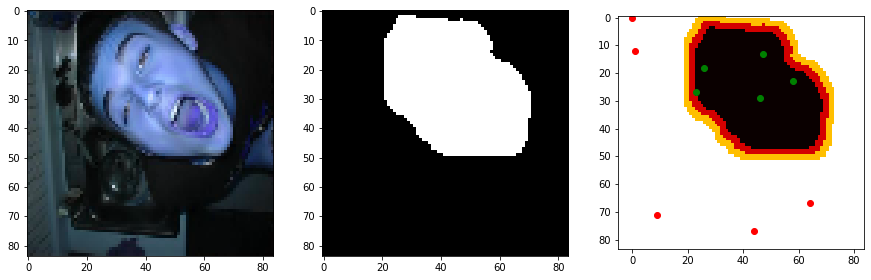

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15,15))
idx = 6262
axs[0].imshow(images[idx])
axs[1].imshow(masks[idx], cmap='gray')
axs[2].imshow(all_masks_with_regions[idx], cmap='hot')
axs[2].scatter(initial_foreground_seeds[idx, :, 1], initial_foreground_seeds[idx, :, 0], c='g')
axs[2].scatter(initial_background_seeds[idx, :, 1], initial_background_seeds[idx, :, 0], c='r')

In [26]:
initial_foreground_seeds[idx, :, 1], initial_foreground_seeds[idx, :, 0]

(array([26., 58., 47., 46., 23.]), array([18., 23., 13., 29., 27.]))

#Model

In [0]:
def calculate_reward_exp(gt_mask, pred_mask, k):
  IoU = calculate_IoU(gt_mask, pred_mask)
  
  return (np.exp(k * IoU) - 1) / (np.exp(k) - 1)

def calculate_reward(gt_mask_with_regions, seed_location, seed_type, gt_mask, pred_mask, k):
  reward_exp = calculate_reward_exp(gt_mask, pred_mask, k)
  reward = -1
  
  gt_type = gt_mask_with_regions[seed_location]
  
  if seed_type == Seed.F:
    
    if gt_type == Seed.SF.val:
      reward = reward_exp
    
    elif gt_type == Seed.WF.val:
      reward = reward_exp - 1  
  
  elif seed_type == Seed.B:
    if gt_type == Seed.SB.val:
      reward = reward_exp
  
    elif gt_type == Seed.WB.val:
      reward = reward_exp - 1
    
  return reward
  

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class DQN(nn.Module):
  def __init__(self):
    super(DQN, self).__init__()
    
    self.conv1 = nn.Conv2d(4,  32,  8, 4)
    self.conv2 = nn.Conv2d(32, 64,  4, 2)
    self.conv3 = nn.Conv2d(64, 64,  3, 1)
    self.conv4 = nn.Conv2d(64, 512, 7, 1)
    
    self.state_value = nn.Linear(256, 1)
    self.advantage_fn = nn.Linear(256, 800)
    self.output = nn.Linear(801, 800)
    
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = self.conv4(x)
    x = F.relu(x)
    
    value_input = x[:, :256, 0, 0]
    advantage_input = x[:,256:, 0, 0]
    
    value_output = self.state_value(value_input)
    advantage_output = self.advantage_fn(advantage_input)
    print(value_output.shape, advantage_output.shape)
    
    pre_output = torch.cat((value_output, advantage_output), 1)
    return self.output(pre_output)

In [0]:
samples = np.empty((10, 84,84,4))
samples[0:9,:,:,:3] = images[0:9]
samples[9,:,:,3]  = masks[9][:,:,0]
samples = np.swapaxes(samples, 1, 3)
samples.shape

IndexError: ignored

In [0]:
model = DQN()
print(model)
model = model.double()
out = model.forward(torch.from_numpy(samples))
pred = out[0].argmax()
print(pred)

DQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 512, kernel_size=(7, 7), stride=(1, 1))
  (state_value): Linear(in_features=256, out_features=1, bias=True)
  (advantage_fn): Linear(in_features=256, out_features=800, bias=True)
  (output): Linear(in_features=801, out_features=800, bias=True)
)


RuntimeError: ignored